# “A ~~Jedi~~ Ph.D. uses the Force for knowledge and defense, never for attack.” 
### The Empire Strikes Back

In [1]:
from sklearn import metrics
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import hdbscan
import pandas as pd
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
import glob

from matplotlib.cm import get_cmap
import matplotlib
# for condense trees in hdbscan
import seaborn as sns

%matplotlib inline

import sklearn.datasets as datasets
from mpl_toolkits.mplot3d import Axes3D

/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/big-dama/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Darth Vaders Tie Fighter component identification by density-based clustering and its use for traffic analysis

Darth Vader piloted this distinctive experimental TIE fighter above the first Death Star, using its blaster cannons and his uncanny abilities with the Force to blast Rebel starfighters into glittering fragments.

![Tie Fighter](images/vader_tie_fighter.PNG)


Appearances

    Star Wars: A New Hope, Star Wars Rebels 

Affiliations

    Galactic Empire 

Dimensions

    Length: 9.2m 
    
Source
    
    https://www.starwars.com/databank/darth-vader-s-tie-fighter

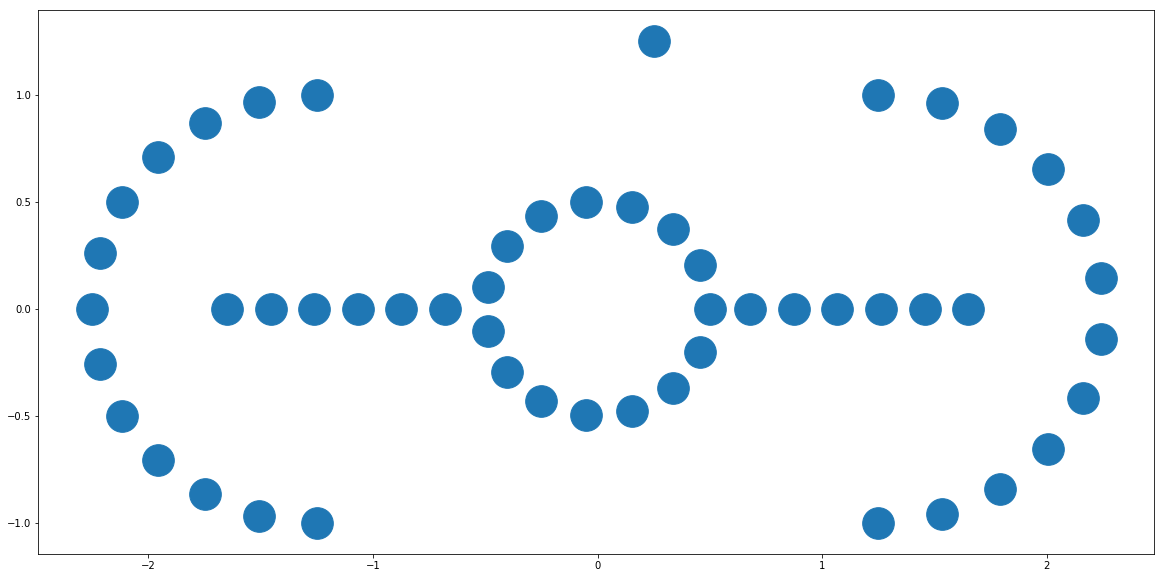

In [23]:
num_points = 100
moon_XY,labels = datasets.make_moons(n_samples=25, noise=0)
right_wing_XY = moon_XY[np.where(labels==0)[0]]
left_wing_XY = moon_XY[np.where(labels==1)[0]]


cabin_XY_temp,labels = datasets.make_circles(n_samples=30, shuffle=True,factor=0.0000001)
cabin_XY = list()
for xy in cabin_XY_temp:
    if np.abs(xy[0]) > 0.000001 or np.abs(xy[1]) > 0.000001:
        cabin_XY.append(xy)
cabin_XY = np.array(cabin_XY)
        
plane1_X = np.linspace(0.68,1.65,6)
plane1_Y = np.zeros([1,6])[0]
plane2_X = np.linspace(-0.68,-1.65,6)
plane2_Y = np.zeros([1,6])[0]


universe_noise_X = [0.25]
universe_noise_Y = [1.25]


X = np.concatenate(( cabin_XY[:,0]*0.5, left_wing_XY[:,1]-1.75, right_wing_XY[:,1]+1.25, plane1_X, plane2_X,universe_noise_X), axis=0)
Y = np.concatenate(( cabin_XY[:,1]*0.5, left_wing_XY[:,0]-1.0, right_wing_XY[:,0], plane1_Y, plane2_Y,universe_noise_Y), axis=0)


tiefighter_dict = {'X' : X,
                'Y' : Y}
tiefighter_df = pd.DataFrame(tiefighter_dict)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,)
ax.scatter(tiefighter_df.X,tiefighter_df.Y, s=1000.0)
fig.savefig('tie_fighter.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)    

# Section 1. DBSCAN

## DBSCAN THEORY

In [24]:
tiefighter_df.to_csv('datasets/tiefighter_df.csv',index=False)
tiefighter_df = pd.read_csv('datasets/tiefighter_df.csv',index_col=False)

![DBSCAN ilustration](images/DBSCAN-Illustration.png)

In this diagram, minPts = 4. Point A and the other red points are core points, because the area surrounding these points in an ε radius contain at least 4 points (including the point itself). Because they are all reachable from one another, they form a single cluster. Points B and C are not core points, but are reachable from A (via other core points) and thus belong to the cluster as well. Point N is a noise point that is neither a core point nor directly-reachable.
(source : https://en.wikipedia.org/wiki/DBSCAN#)

## Section 1.1. KNN Epsilon estimation for DBSCAN

In [25]:
# rule of thumb 1 - minpts >=2*D ; number_of_neighbors = minpts-1 -> 2*D-1
n_nbrs1 = 2*len(tiefighter_df.columns.values) - 1
nbrs1 = NearestNeighbors(n_neighbors=n_nbrs1).fit(tiefighter_df.values)
distances1, indices1 = nbrs1.kneighbors(tiefighter_df.values)
# rule of thumb 2 : minpts >= D+1 ; number_of_neighbors = minpts-1 -> D
n_nbrs2 = len(tiefighter_df.columns.values)
nbrs2 = NearestNeighbors(n_neighbors=n_nbrs2).fit(tiefighter_df.values)
distances2, indices2 = nbrs2.kneighbors(tiefighter_df.values)

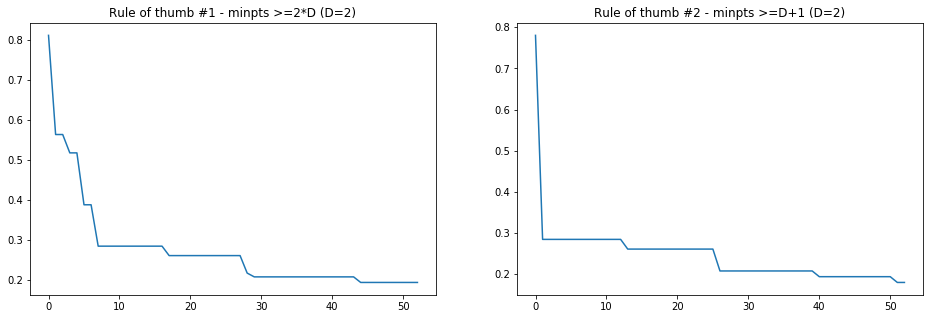

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].set_title('Rule of thumb #1 - minpts >=2*D (D=2)')
ax[0].plot(np.sort(distances1[:,n_nbrs1-1])[::-1])
ax[1].set_title('Rule of thumb #2 - minpts >=D+1 (D=2)')
ax[1].plot(np.sort(distances2[:,n_nbrs2-1])[::-1])
fig.savefig('tie_fighter_k-dist.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)    

## Section 1.2. Clustering

In [48]:
labels_list = list()
min_samples_list = [3,4]
eps_list = np.linspace(0.45, 0.65, num=20, endpoint=True)

for min_samples in min_samples_list:
    for eps in eps_list:
        dbscan_clust = DBSCAN(eps=eps, min_samples=min_samples).fit(tiefighter_df.values)
        labels_list.append(dbscan_clust.labels_)

In [49]:
min_samples_list_df = [min_samples_list[0] for i in range(len(eps_list))]
min_samples_list_df.extend([min_samples_list[1] for i in range(len(eps_list))])
eps_list_df = np.concatenate((eps_list,eps_list),axis=0)
tiefighter_dbscan_results = {'min_samples' : min_samples_list_df,
                       'eps' : eps_list_df,
                       'labels' : labels_list}
tiefighter_dbscan_results_df = pd.DataFrame(tiefighter_dbscan_results)

In [50]:
tiefighter_dbscan_results_df.to_pickle('results/tiefighter_dbscan_results_df.csv')
tiefighter_dbscan_results_df = pd.read_pickle('results/tiefighter_dbscan_results_df.csv')

## Section 1.3. DBCV

In [51]:
cdbw_list = list()
cohesion_list = list()
compactness_list = list()
sep_list = list()
dbcv_list = list()
noise_index_list = list()
clusters_index_list = list()
clusters_labels_list = list()

for labels,i in zip(tiefighter_dbscan_results_df['labels'],range(len(tiefighter_dbscan_results_df['labels']))):
    noise_index = np.where(labels==-1)[0]
    noise_index_list.append(noise_index)
    clusters_index = np.where(labels!=-1)[0]
    clusters_index_list.append(clusters_index)
    clusters_labels = labels[clusters_index]
    clusters_labels_list.append(clusters_labels)
    if len(np.unique(clusters_labels)) > 1 :
        dbcv_list.append(hdbscan.validity_index(tiefighter_df.values[clusters_index], clusters_labels))
    else:
        dbcv_list.append('NA')

tiefighter_dbscan_results_df['Density Based Clustering Validation(dbcv)'] = dbcv_list
tiefighter_dbscan_results_df['noise_index'] = noise_index_list
tiefighter_dbscan_results_df['clusters_index'] = clusters_index_list
tiefighter_dbscan_results_df['clusters_labels'] = clusters_labels_list

tiefighter_dbscan_results_df.to_pickle('results/tiefighter_dbscan_results_df_eval.csv')

In [52]:
tiefighter_dbscan_results_df = pd.read_pickle('results/tiefighter_dbscan_results_df_eval.csv')

# some clustering results contained only 1 cluster - it does not make sense to evaluate clustering of 1 cluster
tiefighter_dbscan_results_df['Density Based Clustering Validation(dbcv)'].replace('NA',-1,inplace=True)
tiefighter_dbscan_results_df.set_index(['eps'], inplace= True)

eps_list = tiefighter_dbscan_results_df.index.values.tolist()

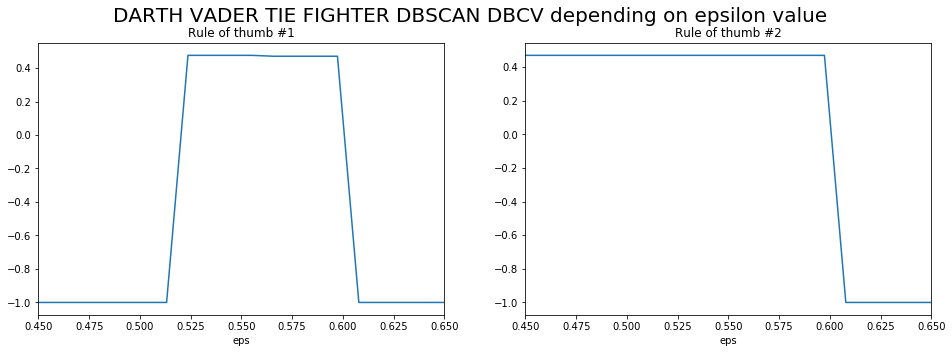

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('DARTH VADER TIE FIGHTER DBSCAN DBCV depending on epsilon value', size=20)
# clustering results for too low or too high values of Eps result in 1 cluster or noise and DBCV is 'NaN'; min value for DBCV is -1 -> replace('NaN', -1)
tiefighter_dbscan_results_df[tiefighter_dbscan_results_df['min_samples']==4]['Density Based Clustering Validation(dbcv)'].plot(kind='line',ax=ax[0],title='Rule of thumb #1')
tiefighter_dbscan_results_df[tiefighter_dbscan_results_df['min_samples']==3]['Density Based Clustering Validation(dbcv)'].plot(kind='line',ax=ax[1],title='Rule of thumb #2')
#ax[2,1].axvline(x=6.14, ymin=0, ymax=1,linestyle='--',color='black')

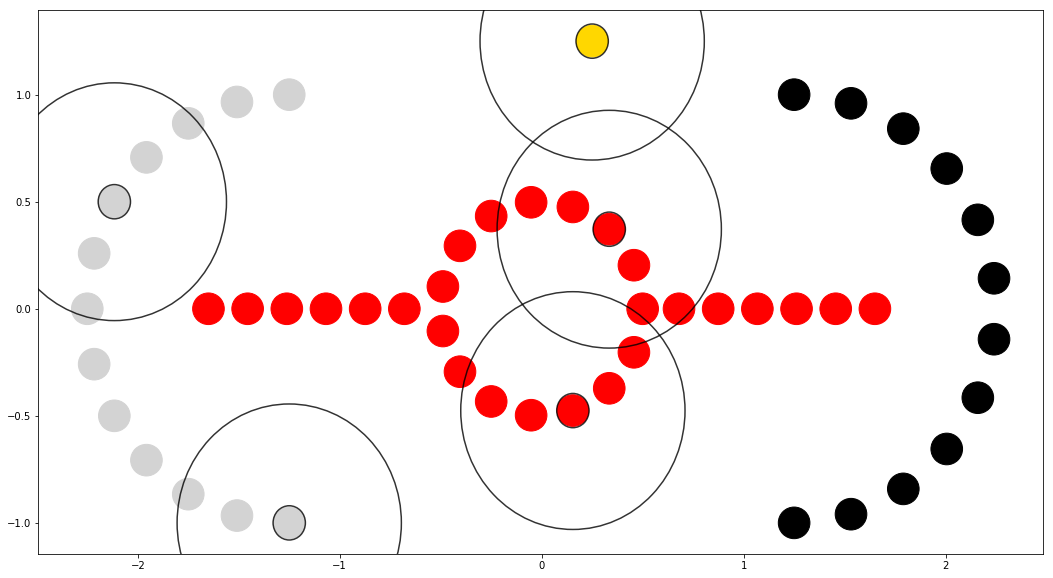

In [68]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
cmap = get_cmap('tab20')  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

row=10
colors = ['red','lightgrey','black','gold']

color_seq = tiefighter_dbscan_results_df['labels'].iloc[row].copy()
color_seq = color_seq.astype(str)
for i in np.unique(tiefighter_dbscan_results_df['labels'].iloc[row]):
    color_seq[np.where(color_seq==str(i))[0]] = matplotlib.colors.rgb2hex(colors[np.mod(i,len(colors))])
#color_seq[52] = 'gold'
    
ax.scatter(tiefighter_df.X,tiefighter_df.Y, s=1000.0,c = color_seq)#tiefighter_optics_results_df['ordered_clusters_labels'][row], cmap='tab20')


for i in [1,2,len(tiefighter_df)-1,15,16]:
    circle = plt.Circle(tiefighter_df.values[i], tiefighter_dbscan_results_df.index[row],facecolor='None', edgecolor='black', linewidth=1.5,alpha=0.8)
    circle1 = plt.Circle(tiefighter_df.values[i], 0.08,facecolor='None', edgecolor='black', linewidth=1.5,alpha=0.8)
    ax.add_artist(circle)
    ax.add_artist(circle1)

fig.savefig('plots/tie_fighter_dbscan.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)    

# Section 2. OPTICS

## Theory

&nbsp;             |  &nbsp;
:-------------------------:|:-------------------------:
![OPTICS_ilustration1](images/optics_1.PNG) | ![OPTICS ilustration2](images/optics_2.PNG) 
![OPTICS_ilustration1](images/optics_3.PNG) | ![OPTICS ilustration2](images/optics_4.PNG) 
![OPTICS_ilustration1](images/optics_5.PNG) | ![OPTICS ilustration2](images/optics_6.PNG) 
![OPTICS_ilustration1](images/optics_7.PNG) | ![OPTICS ilustration2](images/optics_8.PNG) 
![OPTICS_ilustration1](images/optics_9.PNG) | 

source : (Paper Presentation)OPTICS-Ordering Points To Identify The Clustering Structure
Presenter : Anu Singha , Asiya Naz, Rajesh Piryani (South Asian University); April 30, 2012
https://www.slideshare.net/rpiryani/optics-ordering-points-to-identify-the-clustering-structure

## Section 2.1. OPTICS computation in scikit v0.21.2

In [69]:
ordered_reachability_list = list()
ordered_labels_list = list()
ordered_core_distances_list = list()

reachability_list = list()
labels_list = list()
core_distances_list = list()

cluster_hierarchy_list = list()
samples_ordering_list = list()
xi_list = [0.10, 0.11, 0.14, 0.15,0.16, 0.17, 0.18, 0.19, 0.20,0.21,0.25]

# min_cluster_size value is used during cluster extraction - ELKI does not support this, with value 10 we get better granularity of smaller clusters
# the idea(I think) is that we calculate DBSCAN by minpts value, take eps=Inf, compute reachability and then extarct clusters
for xi in xi_list:
    optics_clust = OPTICS(min_samples=3, xi=xi, min_cluster_size=3)
    optics_clust.fit(tiefighter_df.values)

    ordered_reachability_list.append(optics_clust.reachability_[optics_clust.ordering_])
    ordered_labels_list.append(optics_clust.labels_[optics_clust.ordering_])
    ordered_core_distances_list.append(optics_clust.core_distances_[optics_clust.ordering_])

    reachability_list.append(optics_clust.reachability_)
    labels_list.append(optics_clust.labels_)
    core_distances_list.append(optics_clust.core_distances_)

    cluster_hierarchy_list.append(optics_clust.cluster_hierarchy_)
    samples_ordering_list.append(optics_clust.ordering_)

# save/load results
tiefighter_optics_results = {'xi' : xi_list,
                       'ordered_samples' : samples_ordering_list,
                       'ordered_reachability' : ordered_reachability_list,
                       'ordered_core_distances' : ordered_core_distances_list,
                       'ordered_clusters_labels' : ordered_labels_list,
                       'reachability' : reachability_list,
                       'core_distances' : core_distances_list,
                       'clusters_labels' : labels_list,
                       'cluster_hierarchy' : cluster_hierarchy_list}
tiefighter_optics_results_df = pd.DataFrame(tiefighter_optics_results)

In [81]:
tiefighter_optics_results_df['ordered_clusters_labels'].iloc[1]

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0])

In [455]:
tiefighter_optics_results_df.to_pickle('results/tiefighter_optics_results_df_orig.csv')
tiefighter_optics_results_df = pd.read_pickle('results/tiefighter_optics_results_df_orig.csv')

## Section 2.2. scikit v0.21.2 OPTICS results adjustments

Labels are not correctly assigned to OPTICS results in v0.21.2. but the hierarchy is same as in ELKI and I dedicded to  adjust scikit results as it's easiet to add new columns and recompute values than rerun ELKI.

In [70]:
ordered_labels_list = list()
for clusters_hierarchy in tiefighter_optics_results_df['cluster_hierarchy']:
    temp_labels = np.zeros(len(tiefighter_df))
    for cluster,i in zip(clusters_hierarchy[::-1],range(-1,len(clusters_hierarchy)-1)):
        temp_labels[cluster[0]:cluster[1]] = i
    ordered_labels_list.append(temp_labels.astype(int))
tiefighter_optics_results_df['ordered_clusters_labels'] = ordered_labels_list

In [457]:
tiefighter_optics_results_df.to_pickle('tiefighter_optics_results_df_thesis.csv')
tiefighter_optics_results_df = pd.read_pickle('tiefighter_optics_results_df_thesis.csv')

Text(0.08, 0.5, 'reachability distance')

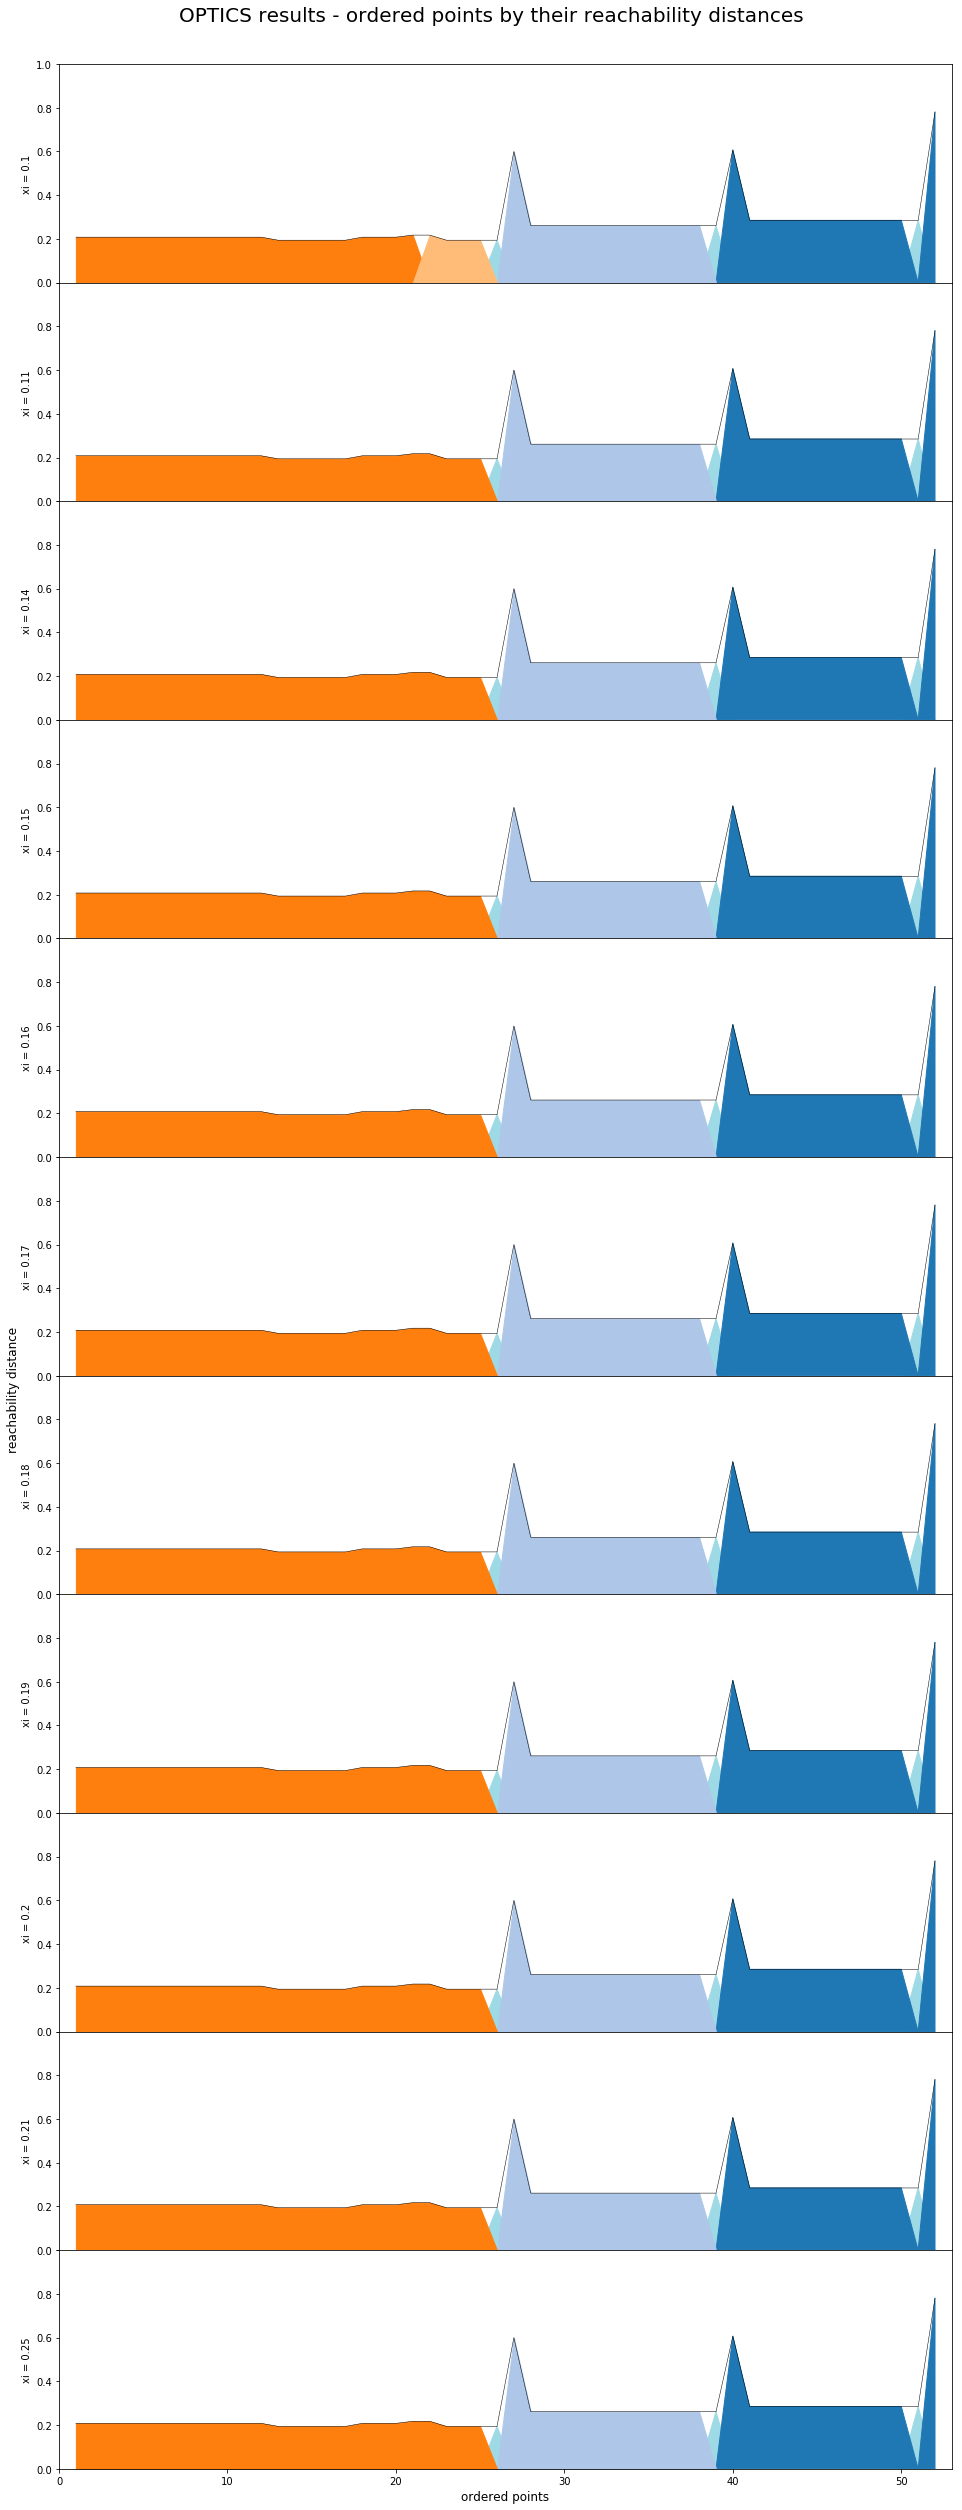

In [71]:
# list of colormapshttps://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
cmap = get_cmap('tab20')  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

fig, ax = plt.subplots(len(tiefighter_optics_results_df['xi']), 1, figsize=(16,40) , sharex=True)

fig.suptitle('OPTICS results - ordered points by their reachability distances', size=20)

for j in range(len(tiefighter_optics_results_df['xi'])):
    ax[j].plot(tiefighter_optics_results_df['ordered_reachability'][j],color='black',linewidth=0.5)
    ax[j].set_xlim([0, len(tiefighter_optics_results_df['ordered_reachability'][j])])
    ax[j].set_ylabel('xi = ' + str(tiefighter_optics_results_df['xi'][j]))
    ax[j].set_ylim([0,1])
    ax[j].set_xlabel('ordered points',size=12)

    if j>0:
        plt.setp(ax[j].get_yticklabels()[-1], visible=False)
    
    # start color filling from parents to children - ie. from back to front
    for i in np.unique(tiefighter_optics_results_df['ordered_clusters_labels'][j]):
        # np.mod cycles through the color set in case there is more clusters than colors
        cluster_x_not = np.where(tiefighter_optics_results_df['ordered_clusters_labels'][j]!=i)[0]
        cluster_y = tiefighter_optics_results_df['ordered_reachability'][j].copy()
        cluster_y[cluster_x_not] = 0
        ax[j].fill_between(np.linspace(0,len(tiefighter_df)-1,len(tiefighter_df),endpoint=True), cluster_y, where=cluster_y>0, interpolate=True, color=colors[np.mod(i,len(colors))])
plt.subplots_adjust(hspace = 0,top=0.96)
fig.text(0.08, 0.5, 'reachability distance', va='center', rotation='vertical',size=12)

In [76]:
tiefighter_optics_results_df['ordered_clusters_labels'].iloc[row]

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  3,  3,  3,  3, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0])

(0, 1)

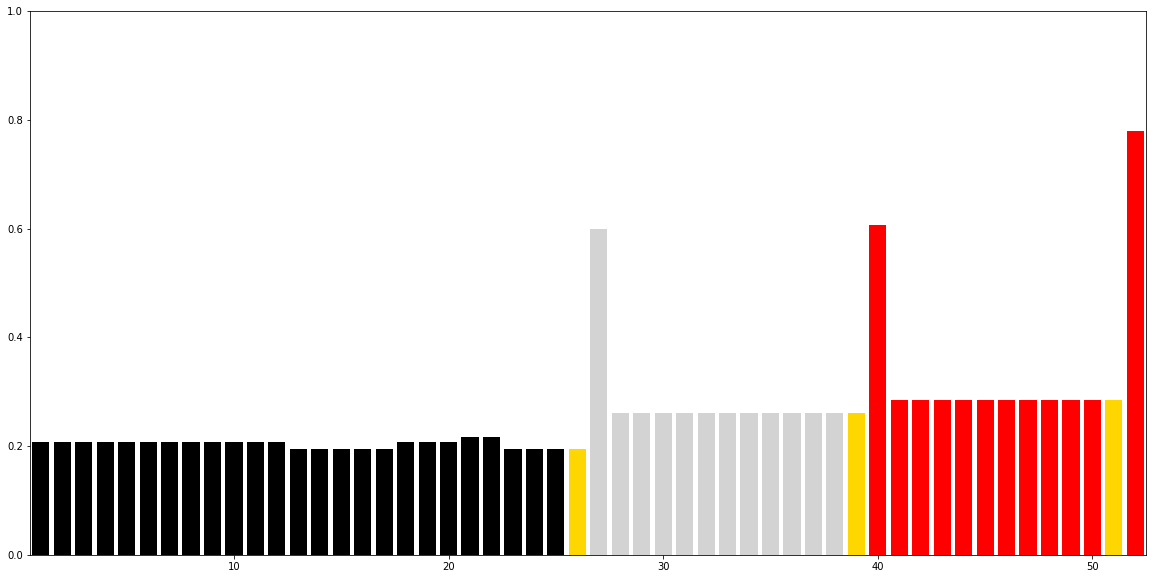

In [78]:
# list of colormapshttps://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
cmap = get_cmap('tab20')  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

fig, ax = plt.subplots(1, 1, figsize=(20,10) , sharex=True)

row=5
colors = ['red','lightgrey','black','gold']

color_seq = tiefighter_optics_results_df['ordered_clusters_labels'].iloc[row].copy()
color_seq = color_seq.astype(str)
for i in np.unique(tiefighter_optics_results_df['ordered_clusters_labels'].iloc[row]):
    color_seq[np.where(color_seq==str(i))[0]] = matplotlib.colors.rgb2hex(colors[np.mod(i,len(colors))])
    
ax.bar(range(len(tiefighter_optics_results_df['ordered_reachability'].iloc[0])),tiefighter_optics_results_df['ordered_reachability'].iloc[0],color=color_seq,linewidth=0.5)
ax.set_xlim([0.5, len(tiefighter_optics_results_df['ordered_reachability'][j])-0.5])
ax.set_ylim([0,1])

#fig.savefig('plots/tie_fighter_optics_reachability_plot.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)    

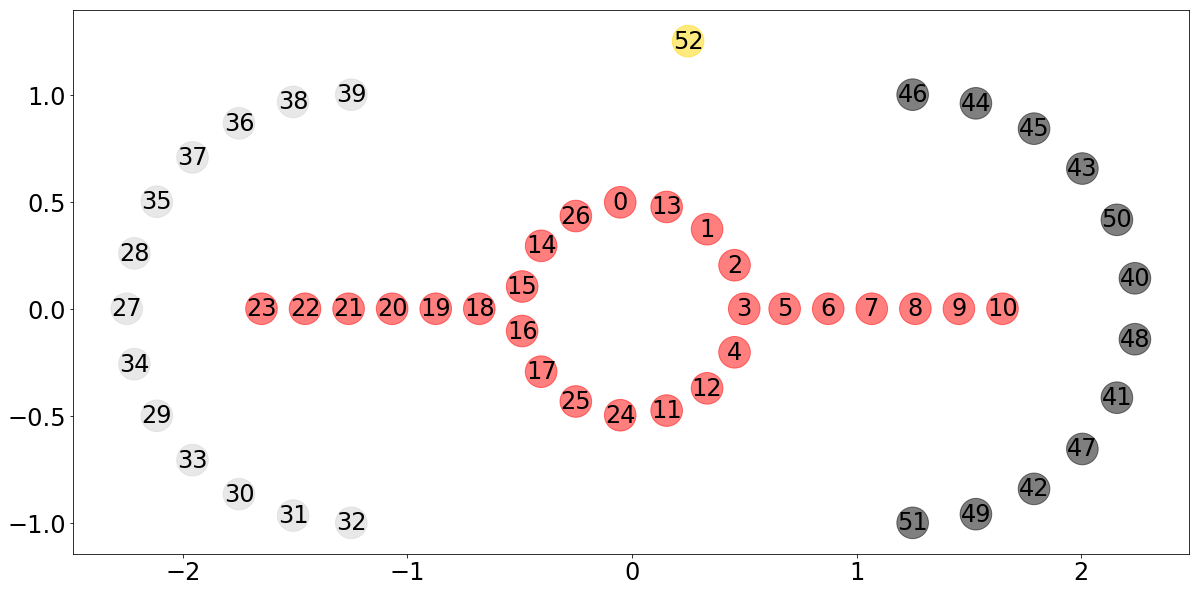

In [592]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
#fig.suptitle('DARTH VADERS TIE FIGHTER with OPTICS xi = 0.23', size=20)

row=0

colors = ['lightgrey','red','gold','black']
color_seq = tiefighter_optics_results_df['ordered_clusters_labels'].iloc[row].copy()
color_seq = color_seq.astype(str)
for i in np.unique(tiefighter_optics_results_df['ordered_clusters_labels'].iloc[row]):
    color_seq[np.where(color_seq==str(i))[0]] = matplotlib.colors.rgb2hex(colors[np.mod(i,len(colors))])

color_seq[52] = 'gold'    
color_seq[39] = 'lightgrey'
color_seq[26] = 'red'
x = tiefighter_df.X[tiefighter_optics_results_df['ordered_samples'].iloc[row]]
x.reset_index(drop=True,inplace=True)
y = tiefighter_df.Y[tiefighter_optics_results_df['ordered_samples'].iloc[row]]
y.reset_index(drop=True,inplace=True)
ax.scatter(x,y, s=1000.0,c = color_seq, alpha =0.5)#tiefighter_optics_results_df['ordered_clusters_labels'][row], cmap='tab20')
for i in range(len(x)):
    plt.text(x[i],y[i],i, ha="center", va="center")
fig.savefig('tie_fighter_optics.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)    

# Section 3. HDBSCAN

# THEORY

HDBSCAN steps : 

    1. Transform the space according to the density/sparsity.
    2. Build the minimum spanning tree of the distance weighted graph.
    3. Construct a cluster hierarchy of connected components.
    4. Condense the cluster hierarchy based on minimum cluster size.
    5. Extract the stable clusters from the condensed tree.

source :
https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

## Section 3.1. Computation by hdbscan library in python
https://github.com/scikit-learn-contrib/hdbscan
https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

In [8]:
labels_list = list()
cluster_hierarchy_list = list()
probabilities_list = list()
persistence_list = list()
outlier_scores_list = list()
relative_validity_list = list()
minimum_spanning_tree_list = list()
condensed_tree_list = list()
min_cl_list = [5]

for min_cl in min_cl_list:
    # hdbscan.robust_single_linkage_.RobustSingleLinkage(cut=0.4, k=5, gamma=5)
    # gamma: Ignore any clusters in the flat clustering with size less than gamma, and declare points in such clusters as noise points.
    # k : Reachability distances will be computed with regard to the k nearest neighbors.
    # cut : The reachability distance value to cut the cluster heirarchy at to derive a flat cluster labelling.
    #
    # cluster_selection_method = ['eom','leaf']
    # allow_single_cluster=True
    hdbscan_clust = hdbscan.HDBSCAN(min_samples=4,min_cluster_size=5,cluster_selection_method='eom',approx_min_span_tree=False,gen_min_span_tree=True)
    hdbscan_clust.fit(tiefighter_df.values)
    #
    labels_list.append(hdbscan_clust.labels_)
    cluster_hierarchy_list.append(hdbscan_clust.single_linkage_tree_)
    probabilities_list.append(hdbscan_clust.probabilities_)
    persistence_list.append(hdbscan_clust.cluster_persistence_)
    outlier_scores_list.append(hdbscan_clust.outlier_scores_)
    relative_validity_list.append(hdbscan_clust.relative_validity_)
    minimum_spanning_tree_list.append(hdbscan_clust.minimum_spanning_tree_)
    condensed_tree_list.append(hdbscan_clust.condensed_tree_)

In [9]:
# create structured pandas
tiefighter_hdbscan_results = {'min_cluster_size' : min_cl_list,
                       'persistence' : persistence_list,
                       'probabilities' : probabilities_list,
                       'outlier_scores' : outlier_scores_list,
                       'labels' : labels_list,
                       'relative_validity' : relative_validity_list,
                       'minimum_spanning_tree' : minimum_spanning_tree_list,
                       'condensed_tree' : condensed_tree_list,
                       'cluster_hierarchy' : cluster_hierarchy_list}
tiefighter_hdbscan_results_df = pd.DataFrame(tiefighter_hdbscan_results)

In [10]:
# save/load results
tiefighter_hdbscan_results_df.to_pickle('results/hdbscan_eom_minpts4_results_df.csv')
tiefighter_hdbscan_results_df = pd.read_pickle('results/hdbscan_eom_minpts4_results_df.csv')

In [11]:
tiefighter_hdbscan_results_df.rename(columns={'labels':'clusters_labels'},inplace=True)
noise_index_list= list()
for labels in tiefighter_hdbscan_results_df['clusters_labels']:
    noise_index_list.append(np.where(labels==-1)[0])
tiefighter_hdbscan_results_df['noise_index'] = noise_index_list

In [12]:
tiefighter_hdbscan_results_df.to_pickle('results/hdbscan_eom_minpts4_results_df_thesis.csv')
tiefighter_hdbscan_results_df = pd.read_pickle('results/hdbscan_eom_minpts4_results_df_thesis.csv')

## Section 3.2. HDBSCAN results visualization by trees

### 1. Transform the space according to the density/sparsity.

![DBSCAN ilustration](DBSCAN-Illustration.png)

### 2. Build the minimum spanning tree of the distance weighted graph.

    "We can build the minimum spanning tree very efficiently via Prim’s algorithm – we build the tree one edge at a time, always adding the lowest weight edge that connects the current tree to a vertex not yet in the tree. "

The algorithm may informally be described as performing the following steps:

    Initialize a tree with a single vertex, chosen arbitrarily from the graph.
    Grow the tree by one edge: of the edges that connect the tree to vertices not yet in the tree, find the minimum-weight edge, and transfer it to the tree.
    Repeat step 2 (until all vertices are in the tree).
    
source : https://en.wikipedia.org/wiki/Prim%27s_algorithm
    

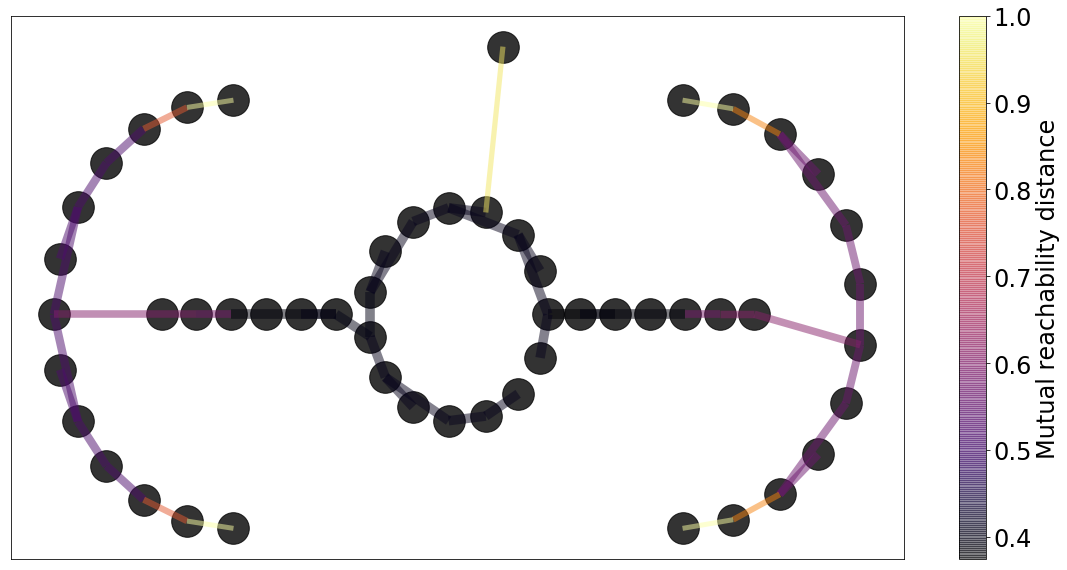

In [13]:
matplotlib.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1, 1, figsize=(20,10))
#fig.suptitle('DARTH VADER TIE FIGHTER HDBSCAN minimum spanning tree', size=20)

for tree,i in zip(tiefighter_hdbscan_results_df['minimum_spanning_tree'][:1],range(len(tiefighter_hdbscan_results_df['cluster_hierarchy']))[:1]):
    #tree.plot(select_clusters=True, selection_palette=sns.color_palette(),axis=ax,colorbar=True)
    tree.plot(axis=ax,colorbar=True,node_size=1000,edge_linewidth=5,edge_cmap='inferno')
cbar_ax = fig.axes[-1]
fig.savefig('plots/tie_fighter_hdbscan_mst.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

### 3. Construct a cluster hierarchy of connected components.

    "Given the minimal spanning tree, the next step is to convert that into the hierarchy of connected components. This is most easily done in the reverse order: sort the edges of the tree by distance (in increasing order) and then iterate through, creating a new merged cluster for each edge. The only difficult part here is to identify the two clusters each edge will join together, but this is easy enough via a union-find data structure."

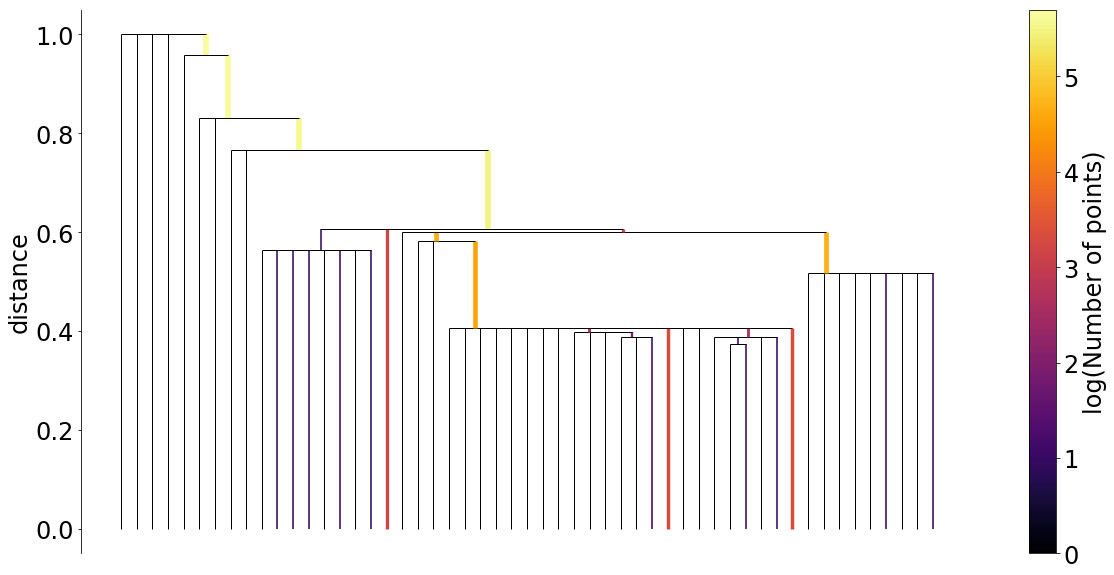

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
#fig.suptitle('DARTH VADER TIE FIGHTER HDBSCAN single linkage tree', size=20)

for tree,i in zip(tiefighter_hdbscan_results_df['cluster_hierarchy'][:1],range(len(tiefighter_hdbscan_results_df['cluster_hierarchy']))[:1]):
    #tree.plot(select_clusters=True, selection_palette=sns.color_palette(),axis=ax,colorbar=True)
    tree.plot(axis=ax,colorbar=True,cmap='inferno')    
fig.savefig('plots/tie_fighter_hdbscan_slt.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

### 4. Condense the cluster hierarchy based on minimum cluster size.

    "walk through the hierarchy and at each split ask if one of the new clusters created by the split has fewer points than the minimum cluster size. If it is the case that we have fewer points than the minimum cluster size we declare it to be ‘points falling out of a cluster’ and have the larger cluster retain the cluster identity of the parent, marking down which points ‘fell out of the cluster’ and at what distance value that happened. If on the other hand the split is into two clusters each at least as large as the minimum cluster size then we consider that a true cluster split and let that split persist in the tree."
    
### 5. Extract the stable clusters from the condensed tree.

    "Intuitively we want the choose clusters that persist and have a longer lifetime; short lived clusters are probably merely artifacts of the single linkage approach. Looking at the previous plot we could say that we want to choose those clusters that have the greatest area of ink in the plot. To make a flat clustering we will need to add a further requirement that, if you select a cluster, then you cannot select any cluster that is a descendant of it."

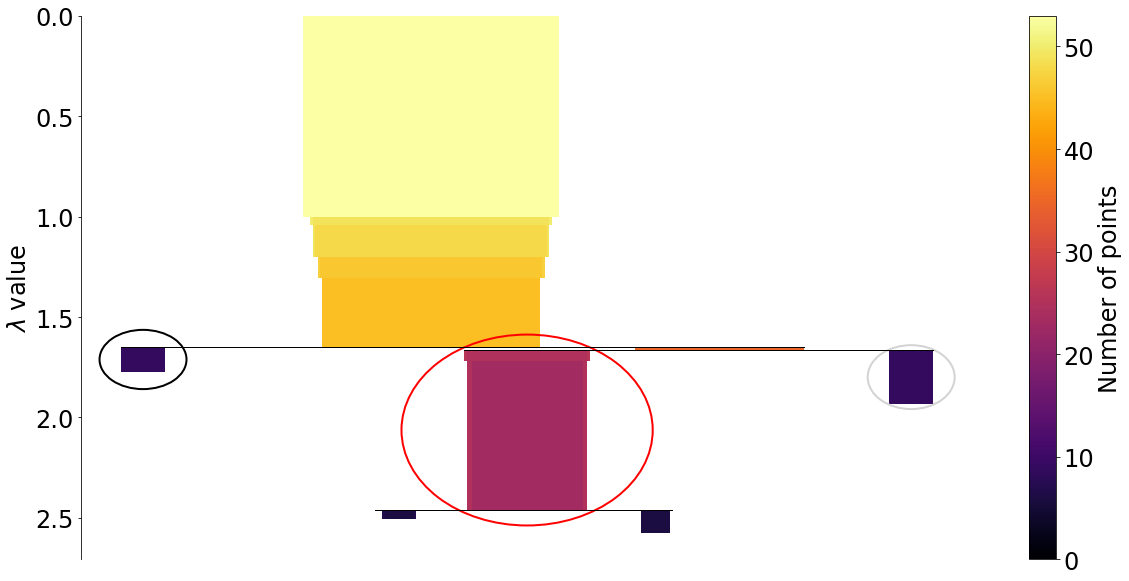

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
#fig.suptitle('DARTH VADER TIE FIGHTER HDBSCAN condensed tree', size=20)

for tree,i in zip(tiefighter_hdbscan_results_df['condensed_tree'][:1],range(len(tiefighter_hdbscan_results_df['cluster_hierarchy']))[:1]):
    #tree.plot(select_clusters=True, selection_palette=sns.color_palette(),axis=ax,colorbar=True,cmap='inferno')
    tree.plot(select_clusters=True, selection_palette=['black','red','lightgrey'],axis=ax,colorbar=True,cmap='inferno')
    #tree.plot(axis=ax[i],colorbar=True)    
fig.savefig('plots/tie_fighter_hdbscan_ct.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

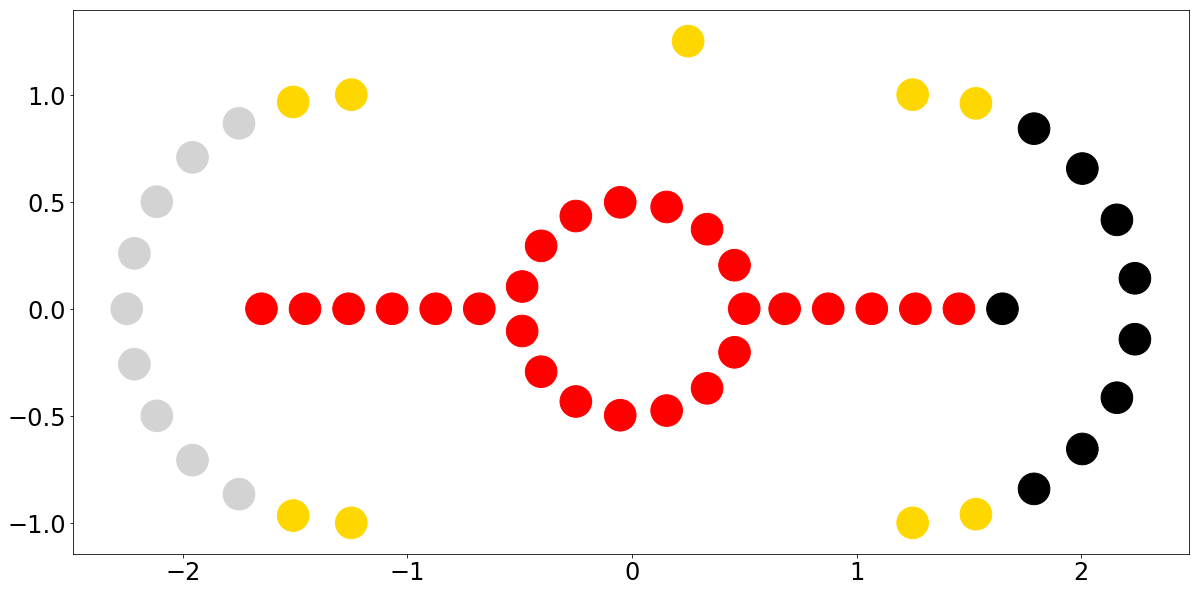

In [16]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
cmap = get_cmap('tab20')  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

row=0

colors = ['black','red','lightgrey','gold']
color_seq = tiefighter_hdbscan_results_df['clusters_labels'][row].copy()
color_seq = color_seq.astype(str)
for i in np.unique(tiefighter_hdbscan_results_df['clusters_labels'][row]):
    color_seq[np.where(color_seq==str(i))[0]] = matplotlib.colors.rgb2hex(colors[np.mod(i,len(colors))])
    
ax.scatter(tiefighter_df.X,tiefighter_df.Y, s=1000.0,c = color_seq)#tiefighter_optics_results_df['ordered_clusters_labels'][row], cmap='tab20')
fig.savefig('plots/tie_fighter_hdbscan_result.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)
#fig.suptitle('DARTH VADERS TIE FIGHTER with HDBSCAN', size=20)

# BONUS : 3D TIE FIGHTER

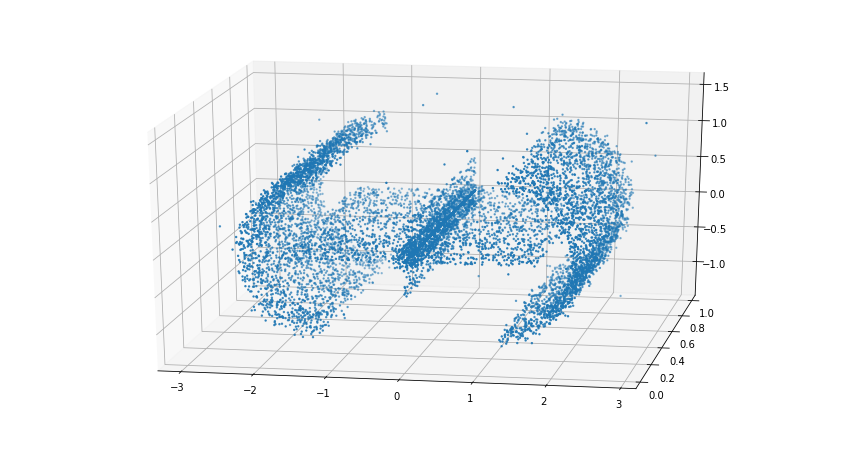

In [313]:
#num_points = 200
moon_XY,labels = datasets.make_moons(n_samples=6000, noise=0.05)
right_wing_XY = moon_XY[np.where(labels==0)[0]]
right_wing_Z = np.random.rand(1,3000)[0]
left_wing_XY = moon_XY[np.where(labels==1)[0]]
left_wing_Z = np.random.rand(1,3000)[0]

plane1_X = np.random.uniform(-1.75,1.75,1750)#np.random.rand(1,num_points)[0]-0.5
plane1_Y = np.zeros([1,1750])[0]
plane1_Z = np.random.rand(1,1750)[0]
plane2_X = np.zeros([1,500])[0]
plane2_Y = np.random.uniform(-0.5,0.5,500)#np.random.rand(1,num_points)[0]
plane2_Z = np.random.rand(1,500)[0]


cabin_XY,labels = datasets.make_circles(n_samples=1000, shuffle=True,factor=0.7)
cabin_Z = np.random.rand(1,1000)[0]

universe_noise_X = np.random.uniform(-3,3,50)
universe_noise_Y = np.random.uniform(-1.5,1.5,50)
universe_noise_Z = np.random.rand(1,50)[0]

cockpit_X = np.zeros([1,2000])[0]
cockpit_Y = np.zeros([1,2000])[0]
cockpit_Z = np.random.rand(1,2000)[0]


X = np.concatenate((cabin_XY[:,0]*0.15, left_wing_XY[:,1]-1.75, right_wing_XY[:,1]+1.25, plane1_X, plane2_X, cockpit_X, universe_noise_X), axis=0)
Y = np.concatenate((cabin_XY[:,1]*0.15, left_wing_XY[:,0]-1.0, right_wing_XY[:,0], plane1_Y, plane2_Y, cockpit_Y, universe_noise_Y), axis=0)
Z = np.concatenate((cabin_Z, left_wing_Z, right_wing_Z, plane1_Z, plane2_Z, cockpit_Z, universe_noise_Z), axis=0)



tiefighter_dict = {'X' : X,
                'Y' : Z,
                'Z' : Y}
tiefighter_df = pd.DataFrame(tiefighter_dict)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tiefighter_df.X,tiefighter_df.Y,tiefighter_df.Z,s=2.0)
ax.view_init(20, -80)


#tiefighter_df.to_csv('tiefighter3d_df.csv',index=False)